# Feldman-Cousins confidence cnterval construction for a single Poisson, with known background and unknown signal

Experiments searching for small signal often face the problem of detecting zero events, while having a known background expectation. For a single counting experiment this means using a Poisson pdf:

\begin{equation}
P(n|\mu) = \frac{(\mu + b)^{n}}{n!}\exp[-(\mu+b)]
\end{equation}

where $\mu$ is the unknown signal, $b$ is the known background and $n$ is the observed number of events.

As is well known, for a given $\mu$ parameter, this Poisson pdf will give a probability of observing different amount of events, $n$. It looks like the following:

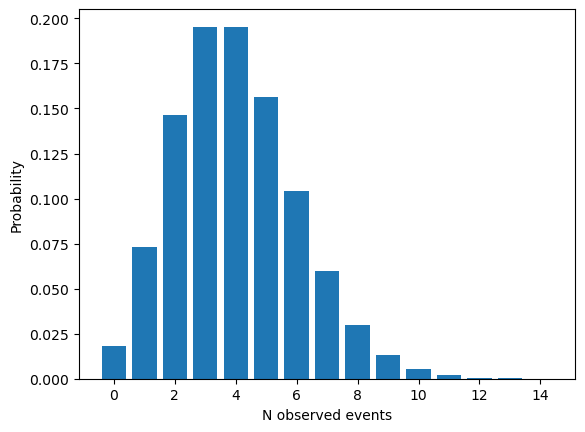

In [4]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
%matplotlib inline

# the Poisson PDF, to be vectorized later
def PoissonPDFS(k, mu):
    return poisson.pmf(k, mu)

Signal = 2.0
Background = 2.0
k = np.arange(0, 15, 1)
Nobs = poisson.pmf(k, Signal+Background)

plt.bar(k, Nobs)
plt.xlabel("N observed events")
plt.ylabel("Probability")
plt.show()

Having observed $N$ events, what can we say about the unknown $\mu$ signal parameter? Feldman and Cousins (Phys.Rev.D57:3873-3889 (1998)) proposed to make a full model inversion, following Neyman. The procedure requires that for a range of physically allowed $\mu$ values one calculates the distribution of observables, and determines an "acceptence region" for each $\mu$, where $\alpha$ fraction of the observations fall. Therefore we have:

\begin{equation}
P(N \in [N_{1},N_{2}]|\mu) = \alpha
\end{equation}

$\alpha$ is called the confidence level (C.L.). The obtained acceptence intervals can be used to arrive at the confidence interval for the parameter of interest:


\begin{equation}
P(\mu \in [\mu_{1},\mu_{2}]) = \alpha
\end{equation}

The way to do it is by plotting for each studied $\mu$ value the corresponding range $[N_{1}, N_{2}]$, with the property mentioned above. Such a plot is called the confidence belt and is illustrated below: 

<img src="ConfidenceBelt.png" width="400">

On the vertical axis is the parameter of interest, $\mu$, and on the horizontal axis is the observable $x$. For each values of $\mu$ one obtains a range of observed values for $x$ from the pdf, such that they cover $\alpha$ percentage of the random draws from the underlying distribution (in our example case, Poisson).

However, note that there is a lot freedom how to determine that area that corresponds to the $\alpha$ fraction. Feldman and Cousins proposed to use the likelihood ratio to determine the $\alpha$ fractional area:


\begin{equation}
R = P(N |\mu)/P(N| \mu_{best})
\end{equation}

where values from the observations are added to the acceptence region in order of their "rank" from the R-value. $R$ is a ratio of two likelihoods: the likelihood of obtaining $N$ given the actual tested $\mu$, and the likelihood of obtaining $N$ given the best-fit physically allowed mean. Values of $N$ (or in the figure above, $x$) are added to the acceptance region for a given $\mu$ in decreasing order of $R$, until the sum of $P(N|\mu$) meets or exceeds the desired confidence level, $\alpha$.

# Example python code for Feldman-Cousins construction for a single Poisson with an unknown signal and known background

Below we put a possible python solution to construct confidence intervals for the unknown signal parameter of a Poisson single counting experiment, with known background. Note that we get a range of confidence intervals for various discrete number of observed events. 

0 : 0.0 - 0.949999988079071
1 : 0.0 - 1.875
2 : 0.0 - 3.0349998474121094
3 : 0.0 - 4.420000076293945
4 : 0.0 - 5.59499979019165
5 : 0.0 - 6.984999656677246
6 : 0.1550000011920929 - 8.46500015258789
7 : 0.8949999809265137 - 9.529999732971191
8 : 1.5099999904632568 - 10.989999771118164
9 : 1.8799999952316284 - 12.295000076293945
10 : 2.634999990463257 - 13.5
11 : 3.0399999618530273 - 14.809999465942383
12 : 4.009999752044678 - 16.0
13 : 4.424999713897705 - 17.049999237060547
14 : 5.505000114440918 - 18.5
15 : 6.484999656677246 - 19.520000457763672
16 : 6.989999771118164 - 20.989999771118164
17 : 8.039999961853027 - 22.014999389648438
18 : 8.470000267028809 - 23.154998779296875
19 : 9.514999389648438 - 24.5049991607666


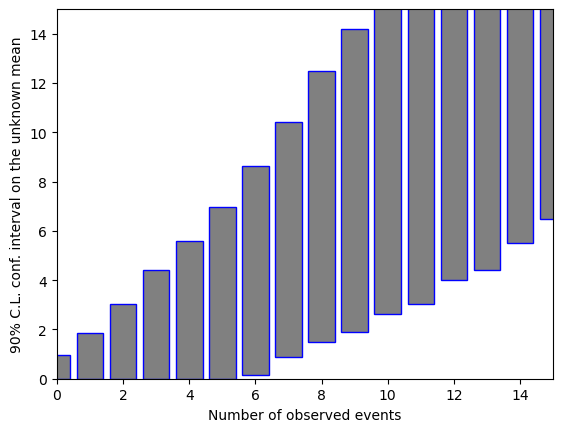

In [2]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

# this scalar function is vectorized below
def PoissonPDFS(k, mu):
    return poisson.pmf(k, mu)

# parameters
dsignal = 5e-03 # precision in the scan of the signal parameter
bkg = 3.0 # known background level
CL = 0.9 # Confidence Level
smax = 30 # maximum value of signal parameter for scanning
nmax = 50 # maximum value used to evaluate the PDF

# vectors of size of signal parameter scan
signal = np.arange(0, smax, dsignal, dtype=np.float32)
bkga = np.full(signal.size, bkg, dtype = np.float32)
bkgn = np.full(nmax, bkg, dtype = np.float32)
mu = bkg + signal
muonly = signal
myzeros = np.zeros(nmax)
nmax_ar = np.arange(nmax, dtype=np.int32)
naccmin_a = []
naccmax_a = []
vecPoissonPDF = np.vectorize(PoissonPDFS)

# scanning with the Signal parameter
for x in np.nditer(mu):
    # vectors of size nmax

    p = vecPoissonPDF(nmax_ar.tolist(),x)

    # get the best signal parameter value
    n_b = nmax_ar - bkgn
    # this is to all elements be >= 0
    sbest = np.maximum(myzeros, n_b)
    b_p_sb = bkgn + sbest
    # the best guess for the mu parameter - a vector
    mubest = np.maximum(myzeros, b_p_sb)
    pbest = vecPoissonPDF(nmax_ar.tolist(), mubest.tolist())

    # save the likelihood ratios
    p_o_pbest = np.divide(p, pbest)

    # merge two arrays
    p_w_ratio = np.vstack((p, p_o_pbest)).T
    n_w_ratio = np.vstack((nmax_ar, p_o_pbest)).T

    # remove nan
    p_w_ratio = p_w_ratio[~np.any(np.isnan(p_w_ratio), axis=1)]
    n_w_ratio = n_w_ratio[~np.any(np.isnan(n_w_ratio), axis=1)]

    # sort, descending order, with index list
    ratio_col = p_w_ratio[:,1]
    p_col = p_w_ratio[:,0]
    n_col = n_w_ratio[:,0]
    
    arr1inds = ratio_col.argsort()
    ratio_col_sort = ratio_col[arr1inds[::-1]] 
    p_col_sort = p_col[arr1inds[::-1]]
    n_col_sort = n_col[arr1inds[::-1]]
    
    sump = 0
    prevp = 0
    acc_n = []
    
    # sum up probabilities until the CL is reached
    for prob,numb in np.nditer([p_col_sort, n_col_sort]):
        prevp = sump
        sump = sump + prob
        if sump <= CL:
            acc_n.append(numb)
        elif prevp <= CL and sump > CL:
            acc_n.append(numb)
    
    # save the minimum and maximum in acceptance regions
    acc_narr = np.array(acc_n)
    naccmax = np.amax(acc_narr)
    naccmin = np.amin(acc_narr)
    naccmax_a.append(naccmax)
    naccmin_a.append(naccmin)
    
# collect limits
naccmax_np = np.array(naccmax_a)
naccmin_np = np.array(naccmin_a)

# create 3D array: (Signal parameter, acc min, acc max)
maparr = np.vstack((muonly, naccmin_np, naccmax_np)).T


# Now loop over observable nobs and check
# which value falls inside the acceptance region
# The mask checks column 1 and 2 for the value to
# be inside nobs, then prints all rows that remain
nobs =  np.arange(0, 20, 1, dtype=np.int32)
ulimit = np.zeros(20)
llimit = np.zeros(20)
for nob in np.nditer(nobs):
    mask = (maparr[:,1] <= nob) & (maparr[:,2] >= nob)
    masked = maparr[mask]
    llimit[nob] = masked[0,0]
    ulimit[nob] = masked[-1,0]
    print(nob, ":" , masked[0,0], "-" , masked[-1,0])



# plot lower and upper limits
fig, ax = plt.subplots()
plt.xlabel('Number of observed events')
plt.ylabel('90% C.L. conf. interval on the unknown mean')
ax.bar(nobs, llimit, color='white')
ax.bar(nobs, ulimit, bottom=llimit, color='gray', edgecolor='blue')
ax.set_ylim(0, 15)
ax.set_xlim(0, 15)
plt.show()


In the output above, the confidence interval is either an upper limit, or a central confidence region, depending on the number of observed events. The boundaries automatically "bend" to zero for the lower limit, not allowing unphysically (e.g. negative) boundaries in the confidence intervals for $\mu$ when 0 events are observed. 

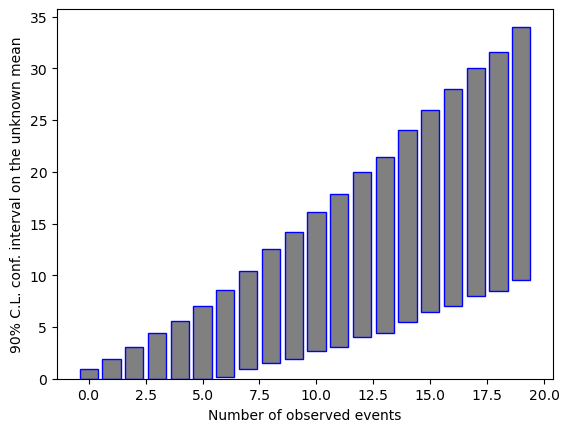

In [3]:
fig, ax = plt.subplots()
plt.xlabel('Number of observed events')
plt.ylabel('90% C.L. conf. interval on the unknown mean')
ax.bar(nobs, llimit, color='white')
ax.bar(nobs, ulimit, bottom=llimit, color='gray', edgecolor='blue')
#ax.set_ylim(0, 15)
#ax.set_xlim(0, 15)
plt.show()
